In [1]:
# Tested on python 3.6.4 
%matplotlib inline

import numpy as np # 1.13.3
from scipy.integrate import odeint # 1.0.0
import scipy.optimize as op
import scipy.stats as stats
import matplotlib.pyplot as plt # 2.1.1
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator

import pandas as pd # 0.22.0
import emcee # 2.2.1
import corner # 2.0.1
import progressbar # 3.34.3
import seaborn as sns # 0.8.1
from cycler import cycler # 0.10.0

from helper import * # helper.py

print('emcee version', emcee.__version__)

# Directories defined here 
DIR_DATA = './data/'
DIR_PLOTS = './plots/'
DIR_OUT = './output/'

emcee version 2.2.1


This jupyter notebook defines the thermodynamic models used in the 2018 Swank et al. paper and carries out MCMC sampling for parameter inference using the [emcee](http://dfm.io/emcee/current/) package. The code in this notebook requires the following data files, which are located in `DIR_DATA`:

    2site_coop_PDZ.csv
    2site_coop_GCN.csv
    2site_coop_AAGCN.csv
    
The results are used to generate plots for Figure 5 and Supplementary Figure S4. Plots are written into `DIR_PLOTS` while MCMC samples are written into `DIR_OUT`. Warning: sample files may be very large.

# Dose response - thermodynamic model

## Model description

We make the assumption that gene expression is proportional to RNAP occupancy, and that RNAP binding to promoters is at thermodynamic equilibrium. This allows the final protein expression level to be written as a function of the equilibrium occupancy of the promoters by RNAP, which itself is a function of the available microstates. Thus the model can be constructed by enumerating all possible binding states of RNAP and any transcription factor it interacts with. For concentrations of nonspecific sites and RNAPs given by $N_{NS}$ and $P$, respectively, a third assumption $P\ll N_{NS}$ allows the occupancy to be written in the following simple form,
\begin{equation}
p_{bound}=\frac{1}{1+\frac{N_{NS}}{PF_{reg}}e^{{\beta\Delta\epsilon_{pd}}}},
\end{equation}
where the effects of the microstate distribution are subsumed into a regulation function $F_{reg}$. $\Delta\epsilon_{pd}$ is the energy difference between RNAP binding to specific versus nonspecific sites. All energies are given in units of $k_BT$, and $\beta=1/k_BT$.

Typically repression is modeled using a purely competitive model where RNAP and the repressor competes for exclusive binding on the promoter. Motivated by our experimental observations, we extend this standard formulation of repression by enumerating four possible states for repressor binding, with the following energies:
\begin{align*}
    \text{no binding} &: 0 \\
    \text{repressor only} &: \Delta\epsilon_{rd} \\
    \text{RNAP only} &:\Delta\epsilon_{pd} \\
    \text{repressor + RNAP} &: \Delta\epsilon_{rd}+\Delta\epsilon_{pd}+\epsilon_{rp}
\end{align*}
In our model, the repressor and RNAP can thus both bind at the same time, and interact with an energy $\epsilon_{rp}$. As $\epsilon_{rp}$ becomes large and positive, the repression tends to that of competitive inhibition, where either species excludes the other from binding. This formulation allows for a continuous transition between competitive and noncompetitive mechanisms of inhibition: as repression becomes noncompetitive, simultaneous binding is possible and thus the promoter exhibits a non-zero leak at full repression. 

We can then write down the regulation functions. For a single repressor of concentration $R$ we have
\begin{equation}
    F_{reg,1}=\frac{1+\frac{R}{N_{NS}}e^{-\beta\Delta\epsilon_{rd}}e^{-\beta\epsilon_{rp}}}{1+\frac{R}{N_{NS}}e^{-\beta\Delta\epsilon_{rd}}}.
\end{equation}
For repressors binding to two sites, we have
\begin{equation}
    F_{reg,2}=\frac{1+\frac{R_1}{N_{NS}}e^{-\beta\Delta\epsilon_{r_1d}}e^{-\beta\epsilon_{r_1p}}+\frac{R_2}{N_{NS}}e^{-\beta\Delta\epsilon_{r_2d}}e^{-\beta\epsilon_{r_2p}}+\frac{R_1R_2}{N_{NS}^2}e^{-\beta(\Delta\epsilon_{r_1d}+\Delta\epsilon_{r_2d})}e^{-\beta(\epsilon_{r_1p}+\epsilon_{r_2p})}e^{-\beta\epsilon_{r12}}}{1+\frac{R_1}{N_{NS}}e^{-\beta\Delta\epsilon_{r_1d}}+\frac{R_2}{N_{NS}}e^{-\beta\Delta\epsilon_{r_2d}}+\frac{R_1R_2}{N_{NS}^2}e^{-\beta(\Delta\epsilon_{r_1d}+\Delta\epsilon_{r_2d})}e^{-\beta\epsilon_{r12}}}
\end{equation}
where the two repressors can interact with an energy $\epsilon_{r12}$. Positive values of $\epsilon_{r12}$ result in positive cooperativity, where the binding of one repressor facilitates the binding of the other.

We make two transformations to Equation 3. First, in dose response experiments, we assume that repressor concentration $R$ is proportional to repressor DNA concentration $R=Bd_R$, as supported by on-chip DNA titration measurements. This allows us to convert repressor concentrations to DNA concentrations, which is the experimentally varying quantity. Second, we simplify all our expressions by defining an effective dissociation constant
\begin{equation}
    K_D=\frac{N_{NS}}{B}e^{+\beta\Delta\epsilon_{rd}},
\end{equation}
which gives the DNA, rather than the repressor concentration for half-maximum occupancy. The effective $K_D$s in the model are related to standard physical dissociation constants $K_{d}=e^{\Delta G^\ominus/k_BT}$ by a multiplicative factor. These transformations result in the simplified equations
\begin{align*}
    F_{reg,1}&=\frac{1+\frac{d_R}{K_D}e^{-\beta\epsilon_{rp}}}{1+\frac{d_R}{K_D}} \\
    F_{reg,2}&=\frac{1+\frac{d_{R1}}{K_{D1}}e^{-\beta\epsilon_{r_1p}}+\frac{d_{R2}}{K_{D2}}e^{-\beta\epsilon_{r_2p}}+\frac{d_{R1}d_{R2}}{K_{D1}K_{D2}}e^{-\beta(\epsilon_{r_1p}+\epsilon_{r_2p})}e^{-\beta\epsilon_{r12}}}{1+\frac{d_{R1}}{K_{D1}}+\frac{d_{R2}}{K_{D2}}+\frac{d_{R1}d_{R2}}{K_{D1}K_{D2}}e^{-\beta\epsilon_{r12}}}. 
\end{align*}
Finally, the protein level is given by a direct proportionality with the occupancy $y=Ap_{bound}$, and fold repressions are given by ratios of protein levels. Thus,
\begin{equation}
    y=\frac{A}{1+\frac{C_0}{F_{reg}}}
\end{equation}
with
\begin{equation*}
    C_0=\frac{N_{NS}}{P}e^{\beta\Delta\epsilon_{pd}}.
\end{equation*}

In [2]:
# Define models

def model_single(A,C0,K,x,Erp):
    Freg = (1+x/K*np.exp(-Erp))/(1+x/K)
    return A/(1+C0/Freg) # Returns protein level (occupancy*A)

def model_dual(A,C0,K1,K2,x1,x2,Erp1,Erp2,Er1r2):
    Freg12 = (1+x1/K1*np.exp(-Erp1)+x2/K2*np.exp(-Erp2)+x1*x2/K1/K2*np.exp(-Erp1-Erp2-Er1r2))/(1+x1/K1+x2/K2+x1*x2/K1/K2*np.exp(-Er1r2))
    return A/(1+C0/Freg12) # Returns protein level (occupancy*A)

## PDZ fits
Read data, fit, and plot PDZ data.

In [3]:
# Define MCMC functions for PDZ fit

def normalprior(param,mu,sigma):
    return np.log( 1.0 / (np.sqrt(2*np.pi)*sigma) ) - 0.5*(param - mu)**2/sigma**2

def lnlike(theta,x,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4):

    A,C0,K1,K2,Erp1,Erp2,Er1r2=theta
    
    ypred4 = model_single(A,C0,K1,x,Erp1)
    ypred3 = model_single(A,C0,K2,x,Erp2)
    ypred2 = model_dual(A,C0,K1,K2,x,x,Erp1,Erp2,0)
    ypred1 = model_dual(A,C0,K1,K2,x,x,Erp1,Erp2,Er1r2)
    
    inv_sigma2_1 = 1/(yerr1**2)
    inv_sigma2_2 = 1/(yerr2**2)
    inv_sigma2_3 = 1/(yerr3**2)
    inv_sigma2_4 = 1/(yerr4**2)

    X1 = np.sum((ypred1-y1)**2*inv_sigma2_1 - np.log(np.pi*2*inv_sigma2_1))
    X2 = np.sum((ypred2-y2)**2*inv_sigma2_2 - np.log(np.pi*2*inv_sigma2_2))
    X3 = np.sum((ypred3-y3)**2*inv_sigma2_3 - np.log(np.pi*2*inv_sigma2_3))
    X4 = np.sum((ypred4-y4)**2*inv_sigma2_4 - np.log(np.pi*2*inv_sigma2_4))
    return -0.5*(X1+X2+X3+X4)

def lnprior(theta,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4):
    A,C0,K1,K2,Erp1,Erp2,Er1r2=theta
    if not (0<A and 0<C0 and 0<K1 and 0<K2 and 0<Erp1 and 0<Erp2): 
        return -np.inf # Hard-cutoff for positive value constraint
    
    log_Pr1 = normalprior(A,5000,1000) # Normal prior for A
    log_Pr2 = normalprior(C0,1e-1,1) # Wide normal prior for C0
    log_Pr3 = normalprior(K1,1e-2,1) # Wide normal prior for KD
    log_Pr4 = normalprior(K2,1e-2,1) # Wide normal prior for KD
    log_Pr5 = normalprior(Erp1,1.4,10) # Normal prior for Erp1
    log_Pr6 = normalprior(Erp2,1.4,10) # Normal prior for Erp2
    log_Pr7 = normalprior(Er1r2,0,10) # Wide normal prior for Er12
    
    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4 + log_Pr5 + log_Pr6 + log_Pr7

def lnprob(theta,x,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4):
    lp = lnprior(theta,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4)
    if not np.isfinite(lp):
        return -np.inf
    return lp+lnlike(theta,x,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4)

def MCMC(x,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,ZFname,
         parameternames,nwalkers,ndim,iterations,pos,tburn,threads,
        DIR_OUT,DIR_PLOTS):
    
    # Initialise MCMC
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2,
                                    args=(x,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4),threads=threads)

    bar = progressbar.ProgressBar(max_value=iterations)
    
    # Run MCMC
    for i, result in enumerate(sampler.sample(pos, iterations=iterations)):
        bar.update(i)

    samples = sampler.chain[:,:,:].reshape((-1,ndim)) # shape = (nsteps*nwalkers, ndim)
    samplesnoburn = sampler.chain[:,tburn:,:].reshape((-1,ndim)) # burn-in removed

    df = pd.DataFrame(samples)
    # Uncomment following line to save
    df.to_csv(path_or_buf=DIR_OUT+'samplesout_'+ZFname+'.csv',sep=',') 

    plottraces2(samples,parameternames,nwalkers,iterations,ZFname,DIR_PLOTS)
    fig = corner.corner(samplesnoburn, labels=parameternames, 
                      show_titles=True,title_fmt=None, 
                      title_kwargs={"fontsize": 12},
                      label_kwargs={"fontsize": 16},
                      plot_contours=True,use_math_text=True)
    fig.savefig(DIR_PLOTS+ZFname+'triangle.png')
    return(samplesnoburn)

 99% (9999 of 10000) |################### | Elapsed Time: 0:31:16 ETA:  0:00:00

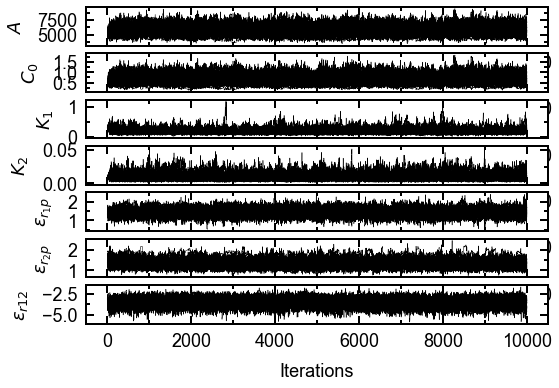

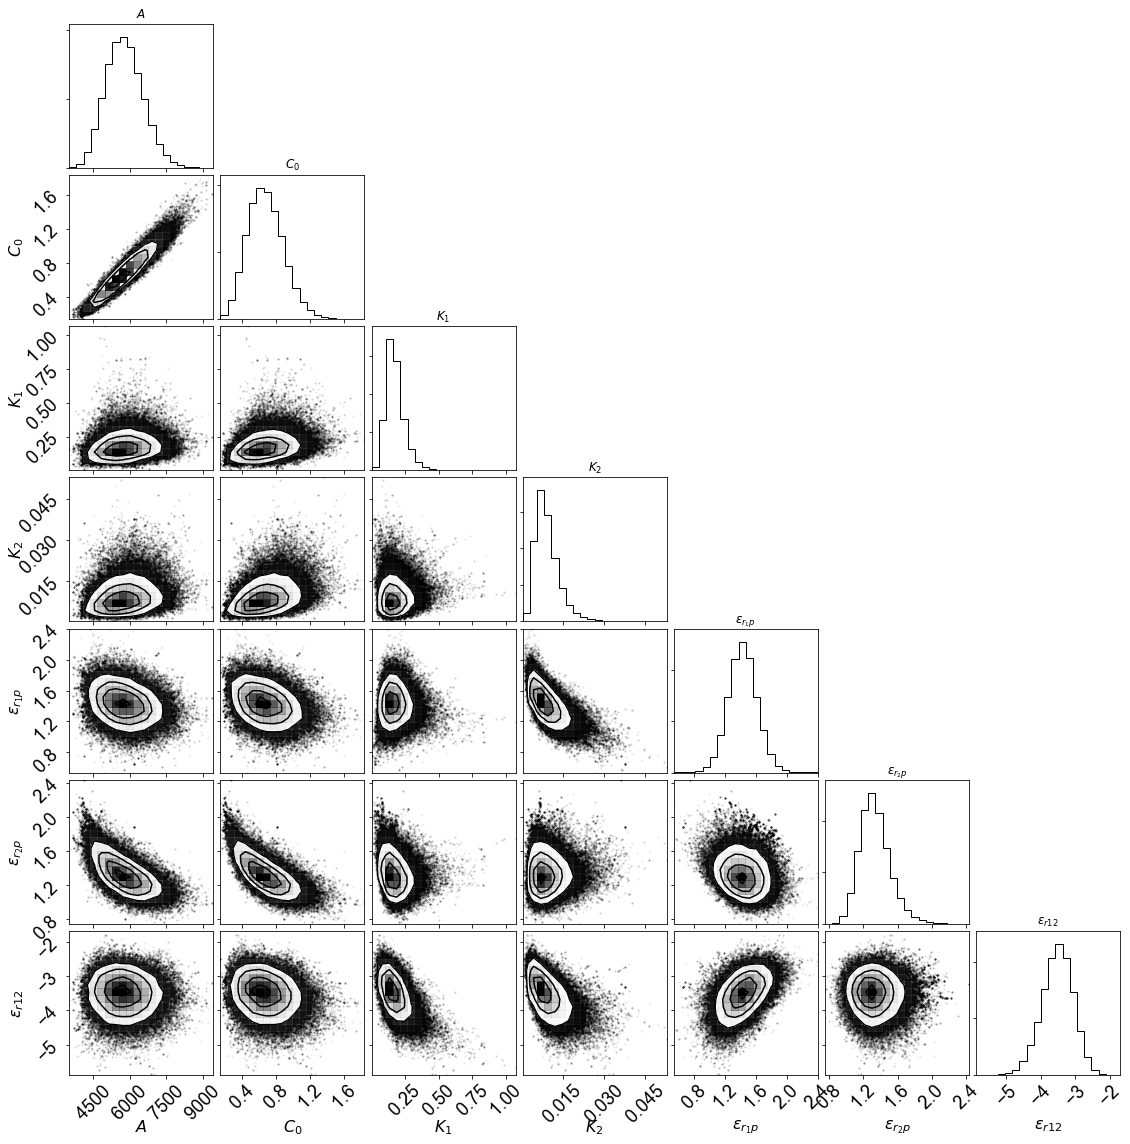

In [4]:
# Read PDZ data
np.random.seed(0) # For reproducible outputs
df = pd.read_csv(DIR_DATA+'2site_coop_PDZ.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-PDZ', 'ADD-L']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-PDZ std', 'ADD-L std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values

# Set up MCMC
parameternames = ["$A$","$C_0$","$K_1$","$K_2$","$\epsilon_{r_1p}$","$\epsilon_{r_2p}$","$\epsilon_{r12}$"]
nwalkers,ndim,iterations,tburn,threads = 50,7,10000,5000,2 # Set threads correctly for parallelisation
pos = [np.array([
    5100*(1+1/10*np.random.randn()),
    0.5*(1+1/10*np.random.randn()),
    0.3*(1+1/10*np.random.randn()),
    0.01*(1+1/10*np.random.randn()),
    1.4*(1+1/10*np.random.randn()),
    1.4*(1+1/10*np.random.randn()),
    -3.4*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC
samples_noburn = MCMC(xs,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,'PDZ_dualbind',
                    parameternames,nwalkers,ndim,iterations,pos,tburn,threads,
                   DIR_OUT,DIR_PLOTS)

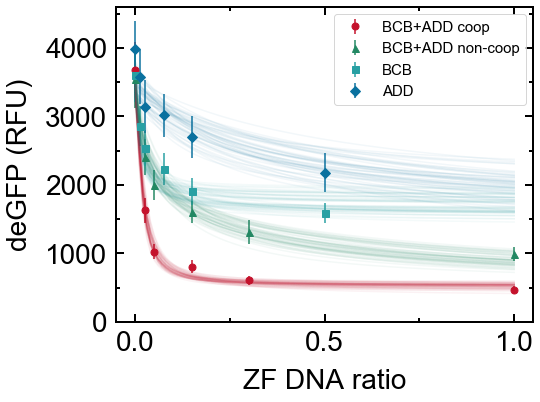

In [5]:
numberofmodeltraces = 50
plottraces(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,
           'PDZ_dualbind_ensemble',model_single,model_dual,DIR_PLOTS,
           numberofmodeltraces=50,samples=samples_noburn,quant=None)

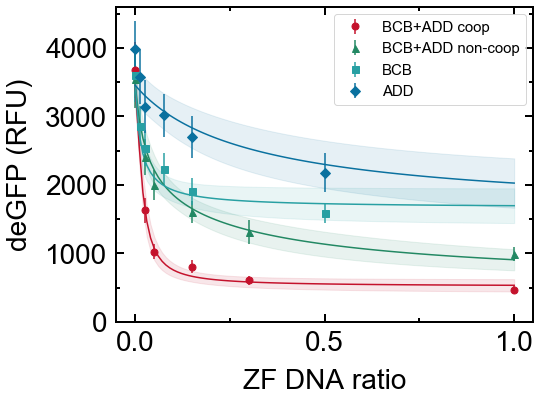

In [6]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs
modelscale = np.linspace(0,1,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))
ypred2 = np.zeros((len(modelscale),numberofmodeltraces))
ypred3 = np.zeros((len(modelscale),numberofmodeltraces))
ypred4 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for A,C0,K1,K2,Erp1,Erp2,Er1r2 in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred4[:,i] = model_single(A,C0,K1,modelscale,Erp1)
    ypred3[:,i] = model_single(A,C0,K2,modelscale,Erp2)
    ypred2[:,i] = model_dual(A,C0,K1,K2,modelscale/2,modelscale/2,Erp1,Erp2,0)
    ypred1[:,i] = model_dual(A,C0,K1,K2,modelscale/2,modelscale/2,Erp1,Erp2,Er1r2)            
    i+=1

# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]
quant2 = [np.mean(ypred2,axis=1)-2*np.std(ypred2,axis=1),
          np.mean(ypred2,axis=1),
          np.mean(ypred2,axis=1)+2*np.std(ypred2,axis=1)]
quant3 = [np.mean(ypred3,axis=1)-2*np.std(ypred3,axis=1),
          np.mean(ypred3,axis=1),
          np.mean(ypred3,axis=1)+2*np.std(ypred3,axis=1)]
quant4 = [np.mean(ypred4,axis=1)-2*np.std(ypred4,axis=1),
          np.mean(ypred4,axis=1),
          np.mean(ypred4,axis=1)+2*np.std(ypred4,axis=1)]

quant = [quant1,quant2,quant3,quant4]

plottraces(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,
           'PDZ_dualbind_maxlike',model_single,model_dual,DIR_PLOTS,
           numberofmodeltraces=50,samples=samples_noburn,quant=quant)

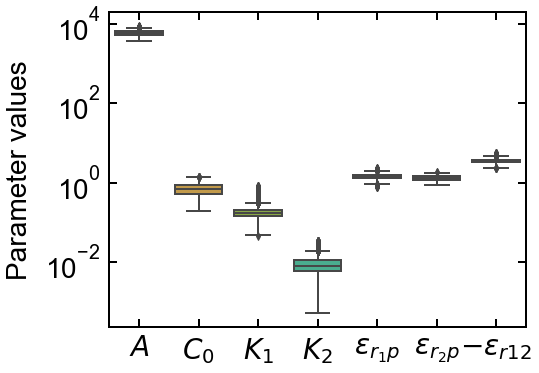

In [7]:
parameternames = ["$A$","$C_0$","$K_1$","$K_2$","$\epsilon_{r_1p}$","$\epsilon_{r_2p}$","$-\epsilon_{r12}$"]
nwalkers = 50
iterations = 10000
tburn = 9900
ZFname = 'PDZ_dualbind'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)

## GCN fits
Read data, fit, and plot GCN data.

In [8]:
# Define MCMC functions for GCN fit

def normalprior(param,mu,sigma):
    return np.log( 1.0 / (np.sqrt(2*np.pi)*sigma) ) - 0.5*(param - mu)**2/sigma**2

def lnlike(theta,x,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4):

    A,C0,K1,K2,Erp1,Erp2,Er1r2=theta
    
    ypred4 = model_single(A,C0,K1,x,Erp1)
    ypred3 = model_single(A,C0,K2,x,Erp2)
    ypred2 = model_dual(A,C0,K1,K2,x,x,Erp1,Erp2,0)
    ypred1 = model_dual(A,C0,K1,K2,x,x,Erp1,Erp2,Er1r2)
    
    inv_sigma2_1 = 1/(yerr1**2)
    inv_sigma2_2 = 1/(yerr2**2)
    inv_sigma2_3 = 1/(yerr3**2)
    inv_sigma2_4 = 1/(yerr4**2)

    X1 = np.sum((ypred1-y1)**2*inv_sigma2_1 - np.log(np.pi*2*inv_sigma2_1))
    X2 = np.sum((ypred2-y2)**2*inv_sigma2_2 - np.log(np.pi*2*inv_sigma2_2))
    X3 = np.sum((ypred3-y3)**2*inv_sigma2_3 - np.log(np.pi*2*inv_sigma2_3))
    X4 = np.sum((ypred4-y4)**2*inv_sigma2_4 - np.log(np.pi*2*inv_sigma2_4))
    return -0.5*(X1+X2+X3+X4)

def lnprior(theta,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4):
    A,C0,K1,K2,Erp1,Erp2,Er1r2=theta
    if not (0<A and 0<C0 and 0<K1 and 0<K2 and 0<Erp1 and 0<Erp2): 
        return -np.inf # Hard-cutoff for positive value constraint

    log_Pr1 = normalprior(A,5000,1000) # Normal prior for A
    log_Pr2 = normalprior(C0,1e-1,1) # Wide normal prior for C0
    log_Pr3 = normalprior(K1,1e-2,1) # Wide normal prior for KD
    log_Pr4 = normalprior(K2,1e-2,1) # Wide normal prior for KD
    log_Pr5 = normalprior(Erp1,1.4,10) # Normal prior for Erp1
    log_Pr6 = normalprior(Erp2,1.4,10) # Normal prior for Erp2
    log_Pr7 = normalprior(Er1r2,0,10) # Wide normal prior for Er12
    
    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4 + log_Pr5 + log_Pr6 + log_Pr7

def lnprob(theta,x,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4):
    lp = lnprior(theta,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,x,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4)

def MCMC(x,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,ZFname,
         parameternames,nwalkers,ndim,iterations,pos,tburn,threads,
        DIR_OUT,DIR_PLOTS):
    
    # Initialise MCMC
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2,
                                  args=(x,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4),threads=threads)

    bar = progressbar.ProgressBar(max_value=iterations)
    # Run MCMC
    for i, result in enumerate(sampler.sample(pos, iterations=iterations)):
        bar.update(i)

    samples = sampler.chain[:,:,:].reshape((-1,ndim)) # shape = (nsteps*nwalkers, ndim)
    samplesnoburn = sampler.chain[:,tburn:,:].reshape((-1,ndim)) # burn-in removed

    df = pd.DataFrame(samples)
    # Uncomment following line to save
    df.to_csv(path_or_buf=DIR_OUT+'samplesout_'+ZFname+'.csv',sep=',') 

    plottraces2(samples,parameternames,nwalkers,iterations,ZFname,DIR_PLOTS)
    fig = corner.corner(samplesnoburn, labels=parameternames, 
                      show_titles=True,title_fmt=None, 
                      title_kwargs={"fontsize": 12},
                      label_kwargs={"fontsize": 16},
                      plot_contours=True,use_math_text=True)
    fig.savefig(DIR_PLOTS+ZFname+'triangle.png')
    return(samplesnoburn)

 99% (9999 of 10000) |################### | Elapsed Time: 0:26:15 ETA:  0:00:00

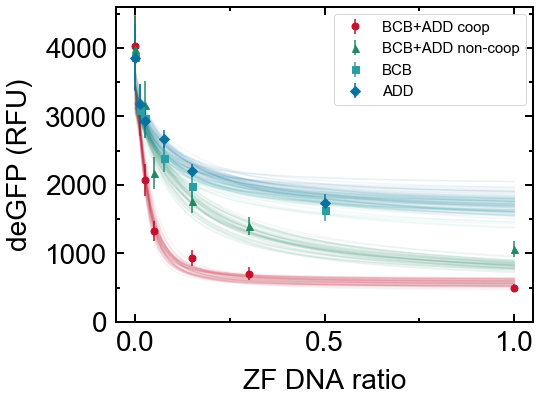

In [9]:
# Read GCN data
np.random.seed(0) # For reproducible outputs
df = pd.read_csv(DIR_DATA+'2site_coop_GCN.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-GCN', 'ADD-GCN']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-GCN std', 'ADD-GCN std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values

# Set up MCMC
parameternames = ["$A$","$C_0$","$K_1$","$K_2$","$\epsilon_{r_1p}$","$\epsilon_{r_2p}$","$\epsilon_{r12}$"]
nwalkers,ndim,iterations,tburn,threads=50,7,10000,5000,8 # Set threads correctly for parallelisation
pos = [np.array([
    5100*(1+1/10*np.random.randn()),
    0.5*(1+1/10*np.random.randn()),
    0.3*(1+1/10*np.random.randn()),
    0.01*(1+1/10*np.random.randn()),
    1.4*(1+1/10*np.random.randn()),
    1.4*(1+1/10*np.random.randn()),
    -3.4*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC and plot
samples_noburn = MCMC(xs,y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,'GCN_dualbind',
                    parameternames,nwalkers,ndim,iterations,pos,tburn,threads,
                   DIR_OUT,DIR_PLOTS)

f,ax = plt.subplots()
numberofmodeltraces = 50
plottraces(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,
           'GCN_dualbind_ensemble',model_single,model_dual,DIR_PLOTS,
           numberofmodeltraces=50,samples=samples_noburn,quant=None)

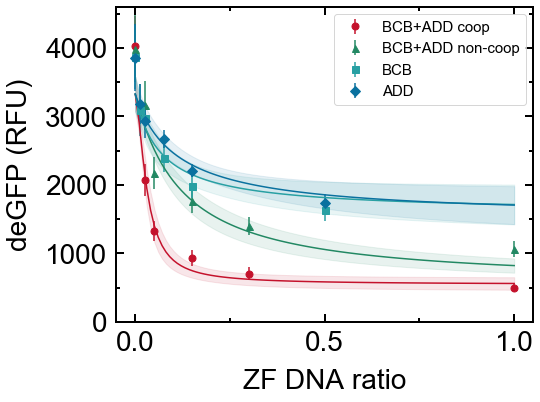

In [10]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs
modelscale=np.linspace(0,1,100)
numberofmodeltraces=1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))
ypred2 = np.zeros((len(modelscale),numberofmodeltraces))
ypred3 = np.zeros((len(modelscale),numberofmodeltraces))
ypred4 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for A,C0,K1,K2,Erp1,Erp2,Er1r2 in samples_noburn[np.random.randint(len(samples_noburn), 
                                                                   size=numberofmodeltraces)]:
    ypred4[:,i] = model_single(A,C0,K1,modelscale,Erp1)
    ypred3[:,i] = model_single(A,C0,K2,modelscale,Erp2)
    ypred2[:,i] = model_dual(A,C0,K1,K2,modelscale/2,modelscale/2,Erp1,Erp2,0)
    ypred1[:,i] = model_dual(A,C0,K1,K2,modelscale/2,modelscale/2,Erp1,Erp2,Er1r2)            
    i+=1
    
# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]
quant2 = [np.mean(ypred2,axis=1)-2*np.std(ypred2,axis=1),
          np.mean(ypred2,axis=1),
          np.mean(ypred2,axis=1)+2*np.std(ypred2,axis=1)]
quant3 = [np.mean(ypred3,axis=1)-2*np.std(ypred3,axis=1),
          np.mean(ypred3,axis=1),
          np.mean(ypred3,axis=1)+2*np.std(ypred3,axis=1)]
quant4 = [np.mean(ypred4,axis=1)-2*np.std(ypred4,axis=1),
          np.mean(ypred4,axis=1),
          np.mean(ypred4,axis=1)+2*np.std(ypred4,axis=1)]

quant = [quant1,quant2,quant3,quant4]

plottraces(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,
           'GCN_dualbind_maxlike',model_single,model_dual,DIR_PLOTS,
           numberofmodeltraces=50,samples=samples_noburn,quant=quant)

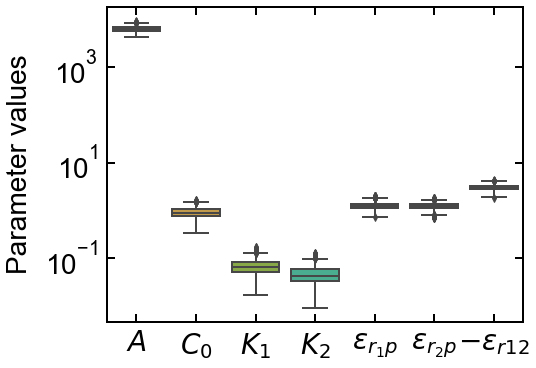

In [11]:
parameternames = ["$A$","$C_0$","$K_1$","$K_2$","$\epsilon_{r_1p}$","$\epsilon_{r_2p}$","$-\epsilon_{r12}$"]
nwalkers = 50
iterations = 10000
tburn = 9900
ZFname = 'GCN_dualbind'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)

## AA-GCN fits
Read data, fit, and plot AA-GCN data.

In [12]:
# Define MCMC functions for AAGCN fit

def normalprior(param,mu,sigma):
    return np.log( 1.0 / (np.sqrt(2*np.pi)*sigma) ) - 0.5*(param - mu)**2/sigma**2

def lnlike(theta,x,y1,yerr1,y2,yerr2):

    A,C0,K,Erp,Er1r2=theta
    
    ypred2 = model_dual(A,C0,K,K,x,x,Erp,Erp,0)
    ypred1 = model_dual(A,C0,K,K,x,x,Erp,Erp,Er1r2)
    
    inv_sigma2_1 = 1/(yerr1**2)
    inv_sigma2_2 = 1/(yerr2**2)
    
    X1 = np.sum((ypred1-y1)**2*inv_sigma2_1-np.log(np.pi*2*inv_sigma2_1))
    X2 = np.sum((ypred2-y2)**2*inv_sigma2_2-np.log(np.pi*2*inv_sigma2_2))

    return -0.5*(X1+X2)

def lnprior(theta,y1,yerr1,y2,yerr2):
    A,C0,K,Erp,Er1r2=theta
    if not (0<A and 0<C0 and 0<K and 0<Erp): 
        return -np.inf # Hard-cutoff for positive value constraint

    log_Pr1 = normalprior(A,5000,1000) # Normal prior for A
    log_Pr2 = normalprior(C0,1e-1,1) # Wide normal prior for C0
    log_Pr3 = normalprior(K,1e-2,1) # Wide normal prior for KD
    log_Pr5 = normalprior(Erp,1.4,10) # Normal prior for Erp
    log_Pr7 = normalprior(Er1r2,0,10) # Wide normal prior for Er12
    
    return log_Pr1+ log_Pr2+ log_Pr3+ log_Pr5+ log_Pr7

def lnprob(theta,x,y1,yerr1,y2,yerr2):
    lp = lnprior(theta,y1,yerr1,y2,yerr2)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,x,y1,yerr1,y2,yerr2)

def MCMC(x,y1,yerr1,y2,yerr2,ZFname,
         parameternames,nwalkers,ndim,iterations,pos,tburn,threads,
        DIR_OUT,DIR_PLOTS):
    
    # Initialise MCMC
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2,
                                  args=(x,y1,yerr1,y2,yerr2),threads=threads)

    bar = progressbar.ProgressBar(max_value=iterations)
    # Run MCMC
    for i, result in enumerate(sampler.sample(pos, iterations=iterations)):
        bar.update(i)

    samples = sampler.chain[:,:,:].reshape((-1,ndim)) # shape = (nsteps*nwalkers, ndim)
    samplesnoburn = sampler.chain[:,tburn:,:].reshape((-1,ndim)) # burn-in removed

    df = pd.DataFrame(samples)
    # Uncomment following line to save
    df.to_csv(path_or_buf=DIR_OUT+'samplesout_'+ZFname+'.csv',sep=',') 

    plottraces2(samples,parameternames,nwalkers,iterations,ZFname,DIR_PLOTS)
    fig = corner.corner(samplesnoburn, labels=parameternames, 
                      show_titles=True,title_fmt=None, 
                      title_kwargs={"fontsize": 12},
                      label_kwargs={"fontsize": 16},
                      plot_contours=True,use_math_text=True)
    fig.savefig(DIR_PLOTS+ZFname+'triangle.png')
    return(samplesnoburn)

 99% (19999 of 20000) |################## | Elapsed Time: 0:43:51 ETA:  0:00:00

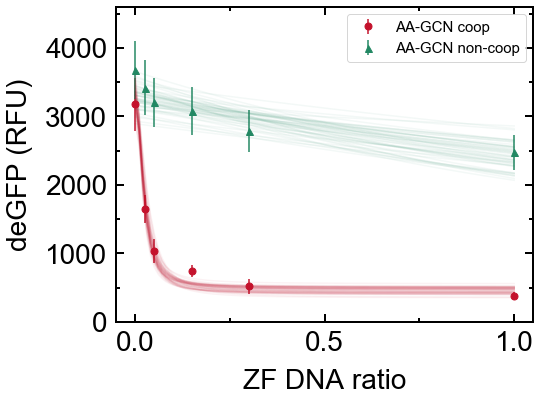

In [13]:
# Read AAGCN data
np.random.seed(0) # For reproducible outputs
df = pd.read_csv(DIR_DATA+'2site_coop_AAGCN.csv',delimiter=',')
ydatnames = ['AA cooperative', 'AA non-cooperative']
yerrnames = ['AA cooperative std', 'AA non-cooperative std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

# Set up MCMC
parameternames = ["$A$","$C_0$","$K$","$\epsilon_{r_p}$","$\epsilon_{r12}$"]
nwalkers,ndim,iterations,tburn,threads=50,5,20000,15000,2 # Set threads correctly for parallelisation
pos = [np.array([
    5100*(1+1/10*np.random.randn()),
    0.5*(1+1/10*np.random.randn()),
    0.1*(1+1/10*np.random.randn()),
    1.4*(1+1/10*np.random.randn()),
    -3.4*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC and plot
samples_noburn = MCMC(xs,y1,yerr1,y2,yerr2,'AAGCN_dualbind',
                    parameternames,nwalkers,ndim,iterations,pos,tburn,threads,
                   DIR_OUT,DIR_PLOTS)

f,ax = plt.subplots()
numberofmodeltraces = 50
plottracesAA(y1,yerr1,y2,yerr2,titration,
             'AAGCN_dualbind_ensemble',model_dual,DIR_PLOTS,
             numberofmodeltraces=50,samples=samples_noburn,quant=None)

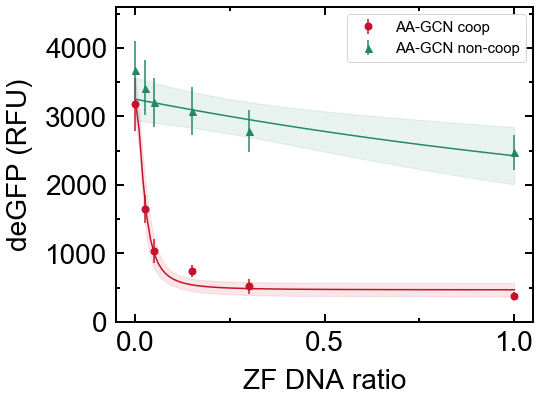

In [14]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs
modelscale = np.linspace(0,1,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))
ypred2 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for A,C0,K,Erp,Er1r2 in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred2[:,i] = model_dual(A,C0,K,K,modelscale/2,modelscale/2,Erp,Erp,0)
    ypred1[:,i] = model_dual(A,C0,K,K,modelscale/2,modelscale/2,Erp,Erp,Er1r2)            
    i+=1

# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]
quant2 = [np.mean(ypred2,axis=1)-2*np.std(ypred2,axis=1),
          np.mean(ypred2,axis=1),
          np.mean(ypred2,axis=1)+2*np.std(ypred2,axis=1)]

quant = [quant1,quant2]

plottracesAA(y1,yerr1,y2,yerr2,titration,'AAGCN_dualbind_maxlike',model_dual,DIR_PLOTS,
             numberofmodeltraces=50,samples=samples_noburn,quant=quant)

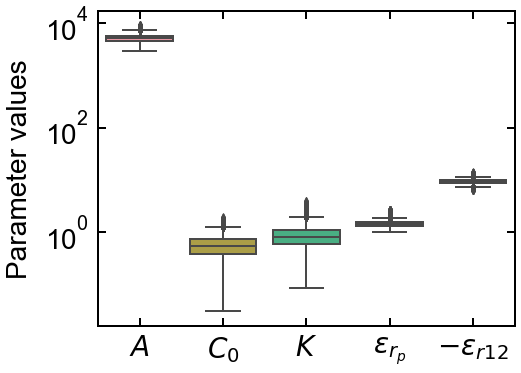

In [15]:
parameternames = ["$A$","$C_0$","$K$","$\epsilon_{r_p}$","$-\epsilon_{r12}$"]
nwalkers = 50
iterations = 20000
tburn = 15000
ZFname = 'AAGCN_dualbind'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)